In [1]:
import os
from matplotlib import pyplot
import numpy as np
from scipy.spatial.transform import Rotation
from PIL import Image
from IPython.display import display
from importlib import reload
from contextlib import closing
import tqdm

In [2]:
import face3drotationaugmentation.dataset300wlp as dataset300wlp
import face3drotationaugmentation.vis as vis
import face3drotationaugmentation.sampling as sampling
from face3drotationaugmentation.graphics import get_hpb, make_rot

In [3]:
def stack_rot(rots):
    '''When rots is a list of single rotations'''
    return Rotation.from_quat(np.stack(list(map(Rotation.as_quat, rots)), axis=0))

def concantenate_rot(rots):
    '''When rots is a list of rotation arrays'''
    return Rotation.from_quat(np.concatenate(list(map(Rotation.as_quat, rots)), axis=0))

In [4]:
with closing(dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'))) as ds300wlp:
    all_baseline_rots = stack_rot(s['rot'] for s in tqdm.tqdm(ds300wlp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3837/3837 [00:26<00:00, 143.90it/s]


In [5]:
print (f"Number of frames: {len(all_baseline_rots)}")

Number of frames: 3837


In [6]:
deg2rad = np.pi/180.

In [38]:
def inv_aflw_rotation_conversion(rot : Rotation):
    '''Rotation object to Euler angles for AFLW and 300W-LP data'''
    P = np.asarray([
        [ 1, 0, 0 ],
        [ 0, 1, 0 ],
        [ 0, 0, -1 ]
    ])
    M = P @ rot.as_matrix() @ P.T
    rot = Rotation.from_matrix(M)
    euler = rot.as_euler('XYZ')
    euler *= np.asarray([1,-1,1])
    return euler

In [48]:
def plot_rotation_distribution(all_rots, alpha=0.1):
    hpb = inv_aflw_rotation_conversion(all_rots)[:,[1,0,2]] # heading pitch bank, aka yaw pitch roll.
    quats = all_rots.as_quat()
    fig, axes = pyplot.subplots(2,3, figsize=(10,6), dpi=180)
    axes = axes.ravel()
    ax = axes[0]
    names = 'yaw pitch roll'.split()
    pairs = [ (0,1), (0,2), (1,2) ]
    for ax, (i,j) in zip(axes[:3],pairs):
        ax.scatter(hpb.T[i]/deg2rad, hpb.T[j]/deg2rad, s=2., alpha=alpha, rasterized=True, edgecolor='none')
        ax.set(xlabel=names[i], ylabel=names[j])
        ax.set(xlim=(-90.,90.),ylim=(-60.,60.))
    names = 'i j k'.split()
    for ax, (i,j) in zip(axes[3:],pairs):
        ax.scatter(quats.T[i], quats.T[j], s=2., alpha=alpha, rasterized=True, edgecolor='none')
        ax.set(xlabel=names[i], ylabel=names[j])
        ax.set(xlim=(-1.,1.),ylim=(-1.,1.))
    pyplot.tight_layout()
    return fig

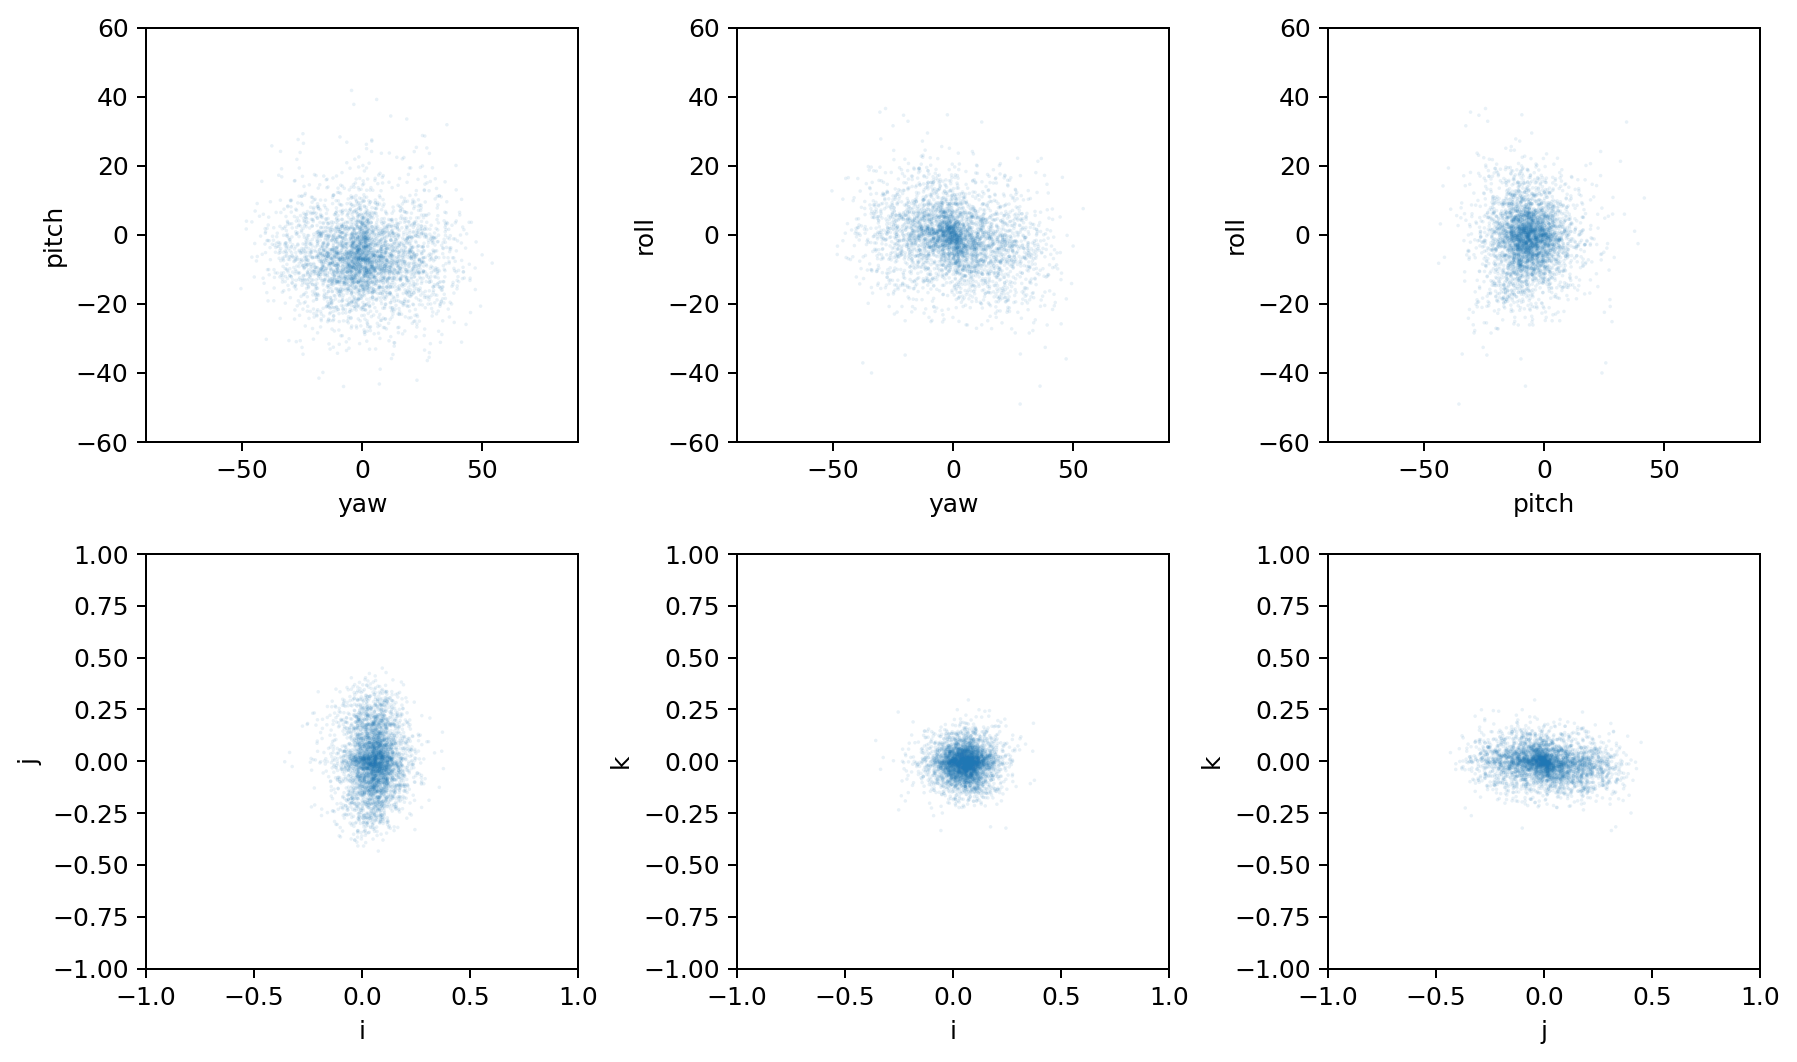

In [49]:
fig = plot_rotation_distribution(all_baseline_rots)

In [50]:
fig.savefig('/tmp/figure_baseline_distribution.svg')

In [32]:
rng = np.random.RandomState()
synthetic_rots = stack_rot([ r for rot in all_baseline_rots for r in sampling.sample_more_face_params(rot,rng,angle_step=5.) ])

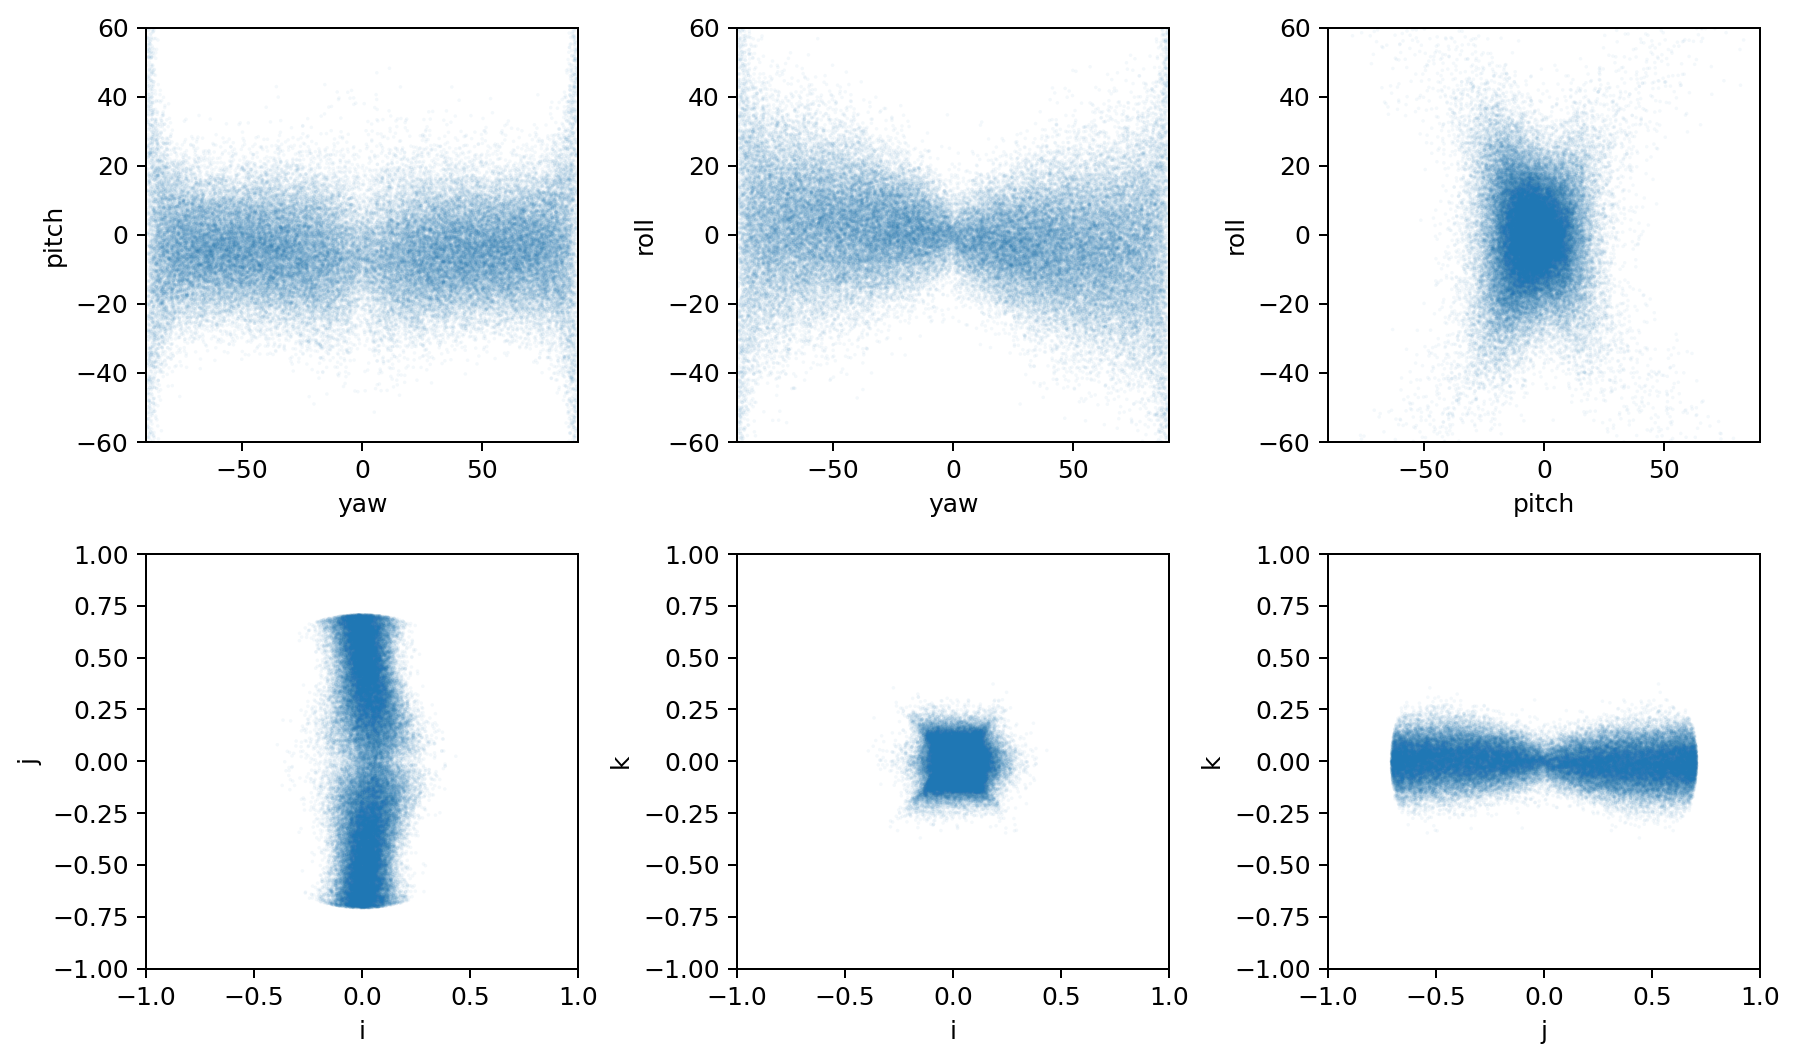

In [51]:
fig2 = plot_rotation_distribution(synthetic_rots,alpha=0.05)

In [52]:
fig2.savefig('/tmp/figure_expanded_distribution.svg')

In [35]:
with closing(dataset300wlp.Dataset300WLP(os.path.join(os.environ['DATADIR'],'300W-LP.zip'), only_originals=False)) as ds300wlpall:
    all_rots = stack_rot(s['rot'] for s in tqdm.tqdm(ds300wlpall))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61225/61225 [02:54<00:00, 351.00it/s]


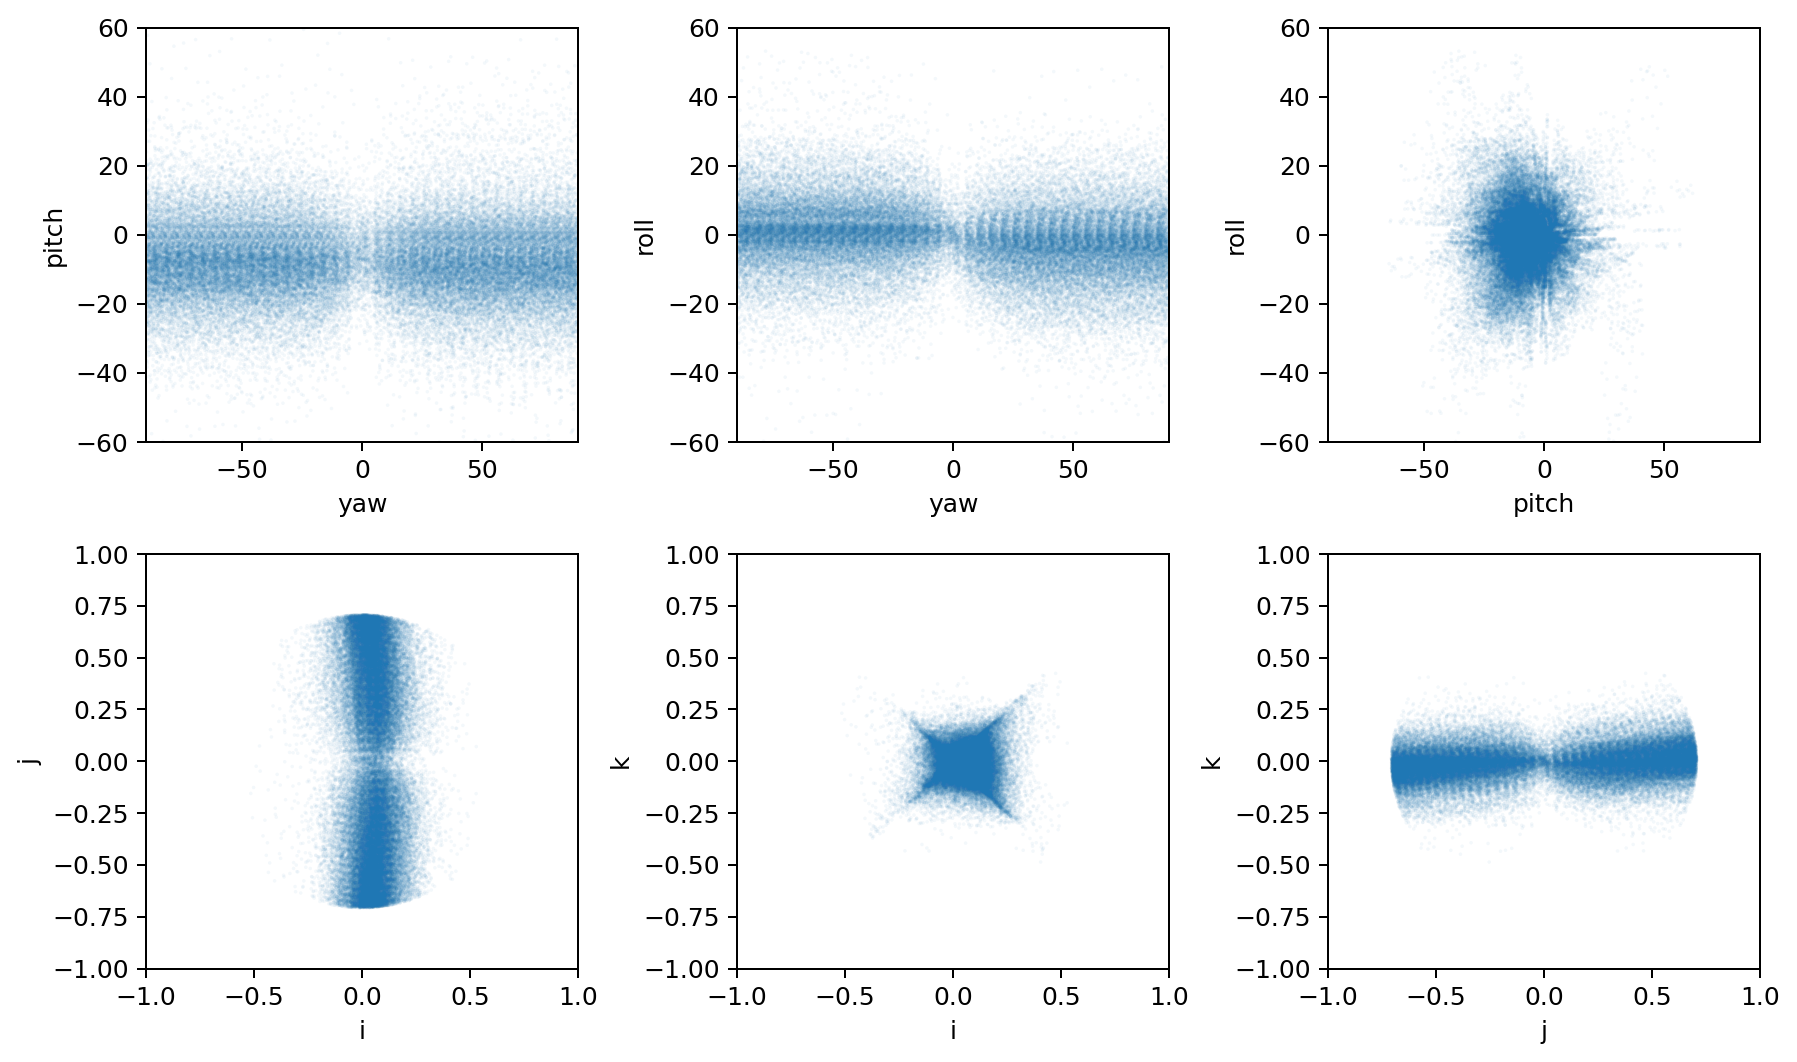

In [53]:
fig3 = plot_rotation_distribution(all_rots,alpha=0.05)

In [54]:
fig3.savefig('/tmp/figure_300wlp_distribution.svg')